In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"]=300
from sklearn.metrics import roc_auc_score


In [6]:
data_dir="./results/mouse_MLP_split_large_ave_dataset_split"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"test_pred_result.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)
with open(preds_path,"rb") as f:
    pred_results=pickle.load(f)


In [7]:
score


{'accuracy': 0.6611328125,
 'precision': 0.6317675159235668,
 'recall': 0.7741463414634147,
 'f1': 0.6957474791758002,
 'confusion_matrix': array([[1121,  925],
        [ 463, 1587]]),
 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.99902248, 0.99951124,
        1.        ]),
 'tpr_all': array([0.00000000e+00, 4.87804878e-04, 9.75609756e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'roc_thresh': array([1.9720169 , 0.97201693, 0.9574645 , ..., 0.01336901, 0.01252898,
        0.00970674], dtype=float32),
 'auc_roc': 0.7235629306439693}

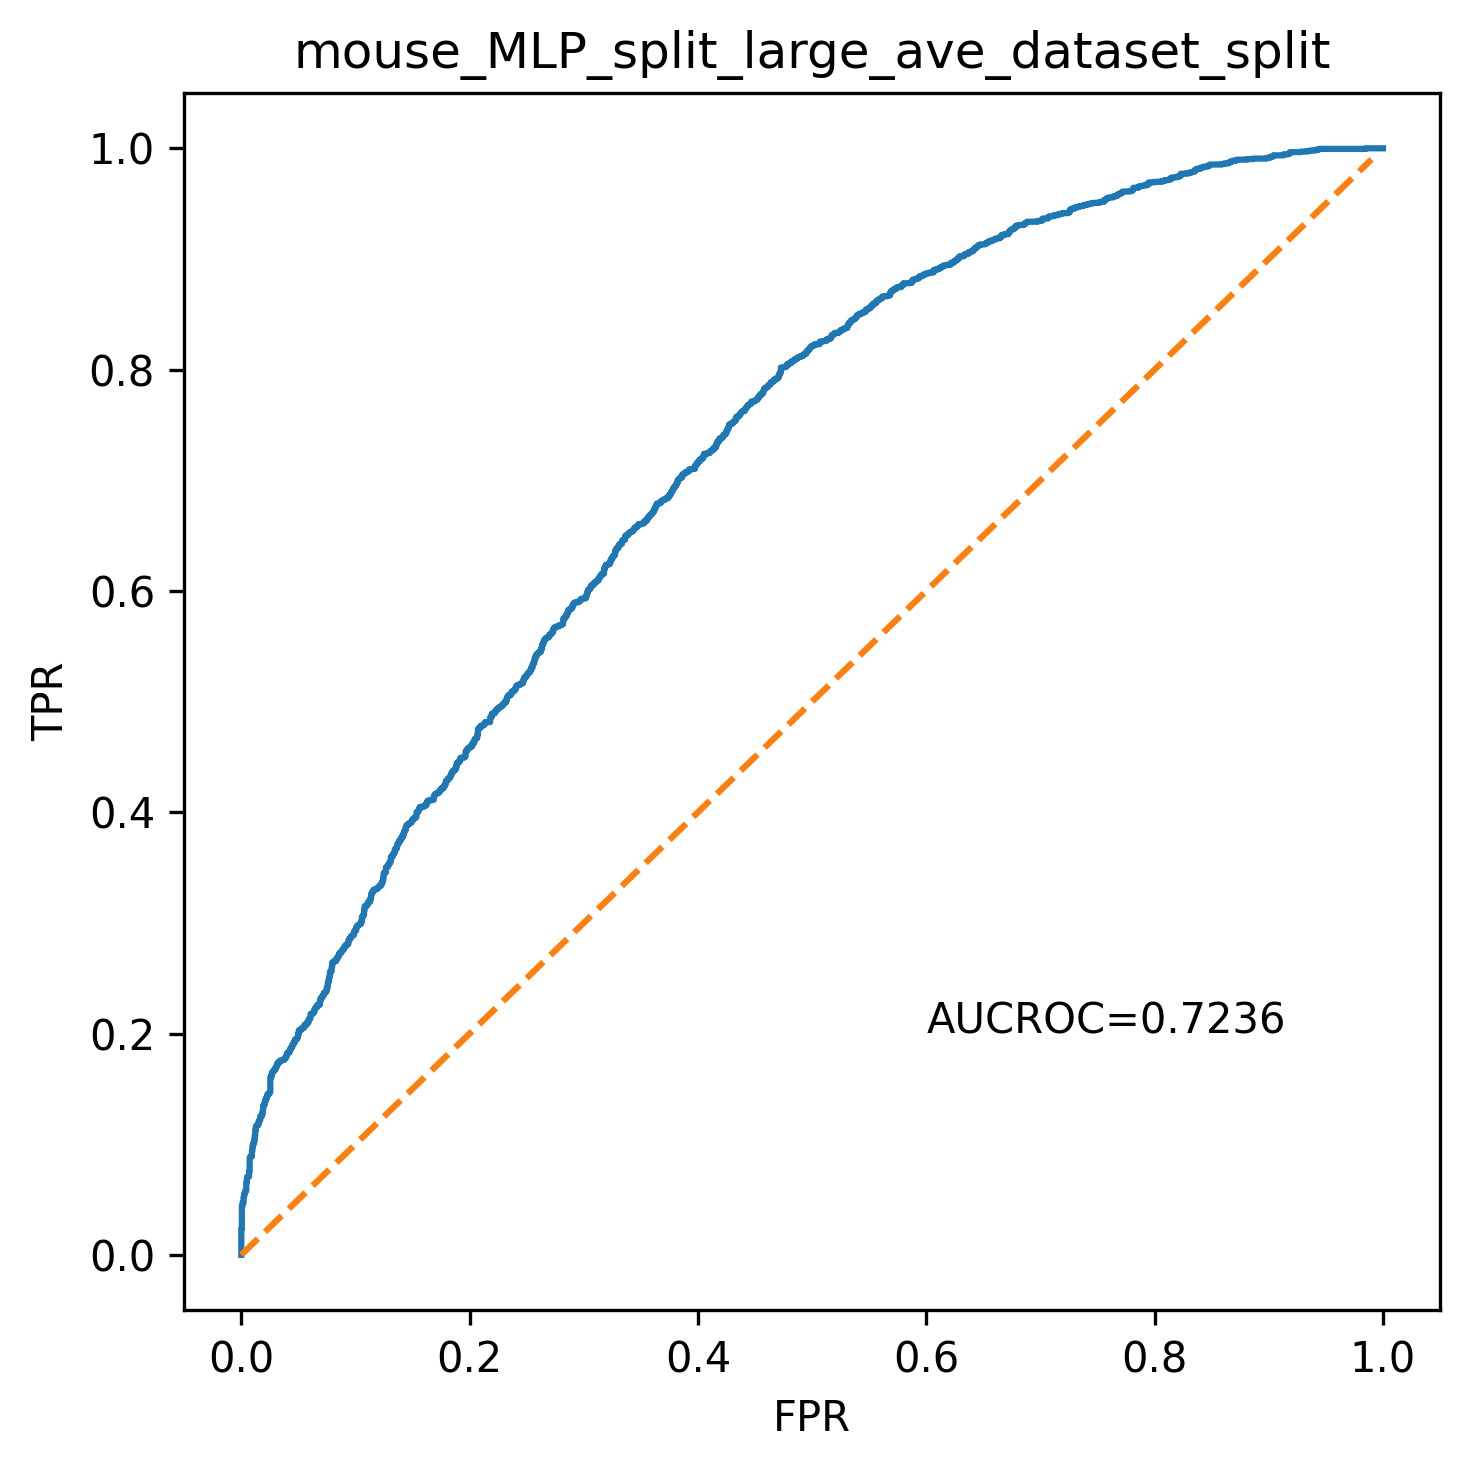

In [8]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
auc_roc=roc_auc_score(pred_results[1],pred_results[2])
plt.plot(score["fpr_all"],score["tpr_all"])
plt.plot(line,line,linestyle="--")
plt.text(0.6,0.2,f"AUCROC={auc_roc:.4f}")
plt.title(os.path.basename(data_dir))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.savefig(f"./results/imgs/aucroc_{os.path.basename(data_dir)}")
